In [3]:
import zeus21
from matplotlib import pyplot as plt
from matplotlib import colors as cc 
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import pickle
from tqdm import tqdm 

from matplotlib.colors import LogNorm
import matplotlib.animation as animation
from IPython.display import HTML
plt.rcParams['animation.embed_limit'] = 100  # Set the embed limit to 100 MB

from powerbox import get_power
from scipy.ndimage import gaussian_filter1d

import warnings 
warnings.filterwarnings("ignore")

from zeus21 import LIM

#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

In [4]:
plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

In [5]:
def Interpolation_SFRD_delta(z0, R0, LineParams, AstroParams, HMFintclass, CosmoParams, use_interpolation, input_delta_array, input_sigmaR):

    if use_interpolation:
        sigmaR = HMFintclass.sigmaRintlog((np.log(R0), z0))

        Nsigmad = 2.0 #how many sigmas we explore
        Nds = 1001 #how many deltas

        # Create a log-spaced array for positive values
        pos = np.logspace(-10, np.log10(Nsigmad), int(Nds/2))  
        neg = -pos[::-1]  # Mirror for negative side
        # Combine negative and positive parts
        deltatab_norm = np.concatenate((neg, pos))

        deltaArray = deltatab_norm * sigmaR
    
    else:
        deltaArray = input_delta_array * input_sigmaR
        sigmaR = input_sigmaR
    
    mArray, deltaArray_Mh = np.meshgrid(HMFintclass.Mhtab, deltaArray, indexing = 'ij', sparse = True)

    sigmaM = HMFintclass.sigmaintlog((np.log(mArray),z0))

    modSigmaSq = sigmaM**2 - sigmaR**2
    indexTooBig = (modSigmaSq <= 0.0)
    modSigmaSq[indexTooBig] = np.inf #if sigmaR > sigmaM the halo does not fit in the radius R. Cut the sum
    modSigma = np.sqrt(modSigmaSq)

    nu0 = CosmoParams.delta_crit_ST / sigmaM
    nu0[indexTooBig] = 1.0
    modd = CosmoParams.delta_crit_ST - deltaArray_Mh
    nu = modd / modSigma

    EPS_HMF_corr = (nu/nu0) * (sigmaM/modSigma)**2.0 * np.exp(-CosmoParams.a_corr_EPS * (nu**2-nu0**2)/2.0 ) * (1.0 + deltaArray_Mh)

    HMF_curr = np.exp(HMFintclass.logHMFint((np.log(mArray),z0)))
    SFRtab_currII = zeus21.sfrd.SFR_II(AstroParams, CosmoParams, HMFintclass, mArray, z0, 0.)

    integrand = EPS_HMF_corr *  HMF_curr * SFRtab_currII * HMFintclass.Mhtab[:,np.newaxis]

    integrand_LIM = EPS_HMF_corr *  HMF_curr * LIM.LineLuminosity(SFRtab_currII, LineParams, AstroParams, CosmoParams, HMFintclass, mArray, z0)  * HMFintclass.Mhtab[:,np.newaxis]

    SFRDbox_flattend = np.trapezoid(integrand, HMFintclass.logtabMh, axis = 0) 

    Lbox_flattened = np.trapezoid(integrand_LIM,HMFintclass.logtabMh, axis = 0)

    if use_interpolation:

        interpolate_funct = interp1d(deltaArray, SFRDbox_flattend, kind='cubic',bounds_error=True)

        SFRDbox_flattend = interpolate_funct(input_delta_array * input_sigmaR)

        interpolate_LIM_funct = interp1d(deltaArray, Lbox_flattened, kind='linear',bounds_error=True)

        Lbox_flattened = interpolate_LIM_funct(input_delta_array * input_sigmaR)


    return SFRDbox_flattend, Lbox_flattened

In [6]:
def LIM_boxes(z0, Lbox, Nbox, delta_box, LineParams, AstroParams, HMFintclass, CosmoParams, use_interpolation):
    
    variance = np.var(delta_box)
    sigmaR = np.sqrt(variance)

    R0 = Lbox / Nbox
    SFRDbox_flattend, Lbox_flattend = Interpolation_SFRD_delta(z0, R0, LineParams, AstroParams, HMFintclass, CosmoParams, use_interpolation, delta_box.flatten(), sigmaR)

    delta_box_sigmaR = delta_box * sigmaR
    SFRD_box = SFRDbox_flattend.reshape(Nbox,Nbox,Nbox)
    L_box = Lbox_flattend.reshape(Nbox,Nbox,Nbox)

    nu_line_rest = LineParams.nu_rest

    if LineParams.OBSERVABLE_LIM == 'Tnu':

        # c1 = uK / Lsun * Mpc^3
        coeff1_LIM = (((zeus21.constants.c_kms * LIM.au.km/LIM.au.s)**3 * (1+z0)**2 / (8*np.pi * (zeus21.cosmology.Hub(CosmoParams, z0) * LIM.au.km/LIM.au.s/LIM.au.Mpc) * (nu_line_rest * LIM.au.Hz)**3 * LIM.ac.k_B)).to(LIM.au.uK * LIM.au.Mpc**3 / LIM.au.Lsun )).value

        # c2 = Lbar = Lsun / Mpc^3 
        coeff2_LIM = 1.

        # --> c1*c2 = uK

    elif LineParams.OBSERVABLE_LIM == 'Inu':

        # nu_rest for CII is in Hz, speed of light in km / s , Hubble in km / s / Mpc --> c1 = cm / sr / Hz
        coeff1_LIM = ((zeus21.constants.c_kms * LIM.au.km/LIM.au.s) / (4*np.pi * (zeus21.cosmology.Hub(CosmoParams, z0) * LIM.au.km/LIM.au.s/LIM.au.Mpc) * nu_line_rest * LIM.au.Hz)) * zeus21.constants.Mpctocm

        # c2 = Lbar = Lsun / Mpc^3 
        coeff2_LIM = 1. / zeus21.constants.Mpctocm**3

    Inu_box = L_box * coeff1_LIM * coeff2_LIM 

    return delta_box_sigmaR, SFRD_box, L_box, Inu_box

In [ ]:
def get_box_slices(z, folder_input, Lbox, Nbox, RSDMODE, CosmoParams_input, AstroParams_input, LineParams_input_1, LineParams_input_2, ZMIN, _islice, seed):

    folder = folder_input + str(Lbox) + ',' + str(Nbox) 
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    filename_all = folder + '/z' + str(round(z,1)) + '.pkl'

    if os.path.isfile(filename_all):
        with open(filename_all, 'rb') as handle:
            temp =  pickle.load(handle)
            coeval_slice_density = temp['delta'][_islice]
            coeval_slice_T21 = temp['T21'][_islice]
            coeval_slice_SFRD = temp['SFRD'][_islice]
            coeval_slice_xHI = temp['xHI'][_islice]
            coeval_slice_LIM_1 = temp['LIM_1'][_islice]
            coeval_slice_LIM_2 = temp['LIM_2'][_islice]
        
    else:

        CosmoParams, ClassyCosmo, CorrFclass_zeus, HMFclass =  zeus21.cosmo_wrapper(CosmoParams_input)

        AstroParams = zeus21.Astro_Parameters(CosmoParams, **AstroParams_input)

        LineParams_1 = zeus21.Line_Parameters(LineParams_input_1)
        LineParams_2 = zeus21.Line_Parameters(LineParams_input_2)

        run_sfrd_module = zeus21.get_T21_coefficients(CosmoParams, ClassyCosmo, AstroParams, HMFclass, zmin=ZMIN)

        PS_zeus = zeus21.Power_Spectra(CosmoParams, AstroParams, ClassyCosmo, CorrFclass_zeus, run_sfrd_module, RSD_MODE = RSDMODE)

        BMF = zeus21.BMF(run_sfrd_module, HMFclass,CosmoParams,AstroParams)

        # run_LIM_module = zeus21.get_LIM_coefficients(CosmoParams, AstroParams, HMFclass, LineParams, zmin=ZMIN)

        # Map_zeus21 = zeus21.CoevalMaps(run_sfrd_module, PS_zeus, z, KIND=1,Lbox=Lbox,Nbox=Nbox,seed=seed)

        # coeval_box_ion = zeus21.maps.make_ion_fields(CosmoParams, run_sfrd_module, ClassyCosmo, CorrFclass_zeus, BMF, z, boxlength=Lbox, ncells=Nbox, seed=seed, r_precision=1., timer=False, logd = False, barrier = None, spherize=False, FLAG_return_densities = 0)[0][0]

        Map_zeus21 = zeus21.maps.T21_bubbles(run_sfrd_module, PS_zeus, z, Lbox, Nbox, seed, CorrFclass_zeus, CosmoParams, AstroParams, ClassyCosmo, BMF)

        delta_box = Map_zeus21.deltamap
        coeval_slice_density = delta_box[_islice]

        coeval_box_T21 = Map_zeus21.T21map
        coeval_slice_T21 = coeval_box_T21[_islice]

        coeval_box_xHI = Map_zeus21.xHI_map
        coeval_slice_xHI = coeval_box_xHI[_islice]

        # box_T21_bubble = (1.-coeval_box_ion) * coeval_box_T21

        temp_1 = LIM_boxes(z, Lbox, Nbox, delta_box, LineParams_1, AstroParams, HMFclass, CosmoParams, use_interpolation = False)

        SFRD_box = temp_1[1]
        coeval_slice_SFRD = SFRD_box[_islice]

        LIM_box_1 = temp_1[3]
        coeval_slice_LIM_1 = LIM_box_1[_islice]

        temp_2 = LIM_boxes(z, Lbox, Nbox, delta_box, LineParams_2, AstroParams, HMFclass, CosmoParams, use_interpolation = False)

        LIM_box_2 = temp_2[3]
        coeval_slice_LIM_2 = LIM_box_2[_islice]

        with open(filename_all, 'wb') as handle:
            pickle.dump({'delta': delta_box, 'T21': coeval_box_T21, 'SFRD': SFRD_box, \
                'xHI': coeval_box_xHI, 'LIM_1': LIM_box_1, 'LIM_2': LIM_box_2}, handle)

    return 

In [ ]:
zmin = 6.
zmax = 20.
Npt_z = 11
zvals = np.linspace(zmax,zmin,Npt_z)

Lbox = 600
Nbox = 150

In [30]:
fstar_vals = np.linspace(0.01,1,10)
fesc_vals = np.linspace(0.01,1,10)
omega_M_vals = np.linspace(0.06,0.24,10)

RSDMODE = 0
CosmoParams_input_use = zeus21.Cosmo_Parameters_Input()
LineParams_input_use_1 = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 nu_rest = 1.897e12, 
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 2,  
                 LINE_MODEL = 'Lagache18',
                 alpha_SFR_0 = 1.4-0.07*10,
                 beta_SFR_0 = 7.1-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_z = 0.,
                 sigma_LSFR = 0.,
                 )
LineParams_input_use_2 = zeus21.LineParams_Input(\
                 LINE = 'OIII',
                 nu_rest = 6.042e14, 
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 2,  
                 LINE_MODEL = 'Yang24',
                 alpha_SFR_0 = 9.82e-2,
                 beta_SFR_0 = 6.90e-1,
                 line_N = 2.75e7,
                 line_SFR1 = 1.24e2,
                 sigma_LSFR = 0.,
                 )

for i in fstar_vals:
    AstroParams_input = {'epsstar':i}
    for zz in range(len(zvals)):    
        folder = './boxes_mod_fstar' + str(i) + '_'
        get_box_slices(zvals[zz], folder, Lbox, Nbox, RSDMODE, CosmoParams_input_use, AstroParams_input, LineParams_input_use_1, LineParams_input_use_2, 5., 0, 1605)

for i in fesc_vals:
    AstroParams_input = {'fesc10':i}
    for zz in range(len(zvals)):    
        folder = './boxes_mod_fesc10' + str(i) + '_'
        get_box_slices(zvals[zz], folder, Lbox, Nbox, RSDMODE, CosmoParams_input_use, AstroParams_input, LineParams_input_use_1, LineParams_input_use_2, 5., 0, 1605)

for i in range(len(omega_M_vals)):
    CosmoParams_input_use.omegac = omega_M_vals[i]
    for zz in range(len(zvals)):    
        folder = './boxes_mod_omC' + str(i) + '_'
        get_box_slices(zvals[zz], folder, Lbox, Nbox, RSDMODE, CosmoParams_input_use, AstroParams_input, LineParams_input_use_1, LineParams_input_use_2, 5., 0, 1605)

0.01 0.1201075 0.1
0.12 0.1201075 0.1
0.23 0.1201075 0.1
0.34 0.1201075 0.1
0.45 0.1201075 0.1
0.56 0.1201075 0.1
0.67 0.1201075 0.1
0.78 0.1201075 0.1
0.89 0.1201075 0.1
1.0 0.1201075 0.1
0.1 0.1201075 0.01
0.1 0.1201075 0.12
0.1 0.1201075 0.23


KeyboardInterrupt: 

In [34]:
fstar_vals = np.linspace(0.01,1,10)
fesc_vals = np.linspace(0.01,1,10)
omega_M_vals = np.linspace(0.06,0.24,10)
def cross_correlation_real_plot(zvals_all, Lbox, Nbox):

#    folder = './boxes_' + str(Lbox) + ',' + str(Nbox) 
    plt.figure(figsize=(6,4))
    _islice = 0 

    for i in omega_M_vals[:4]:

        folder = './boxes_mod_omC' + str(list(omega_M_vals).index(i)) + '_'+ str(Lbox) + ',' + str(Nbox) 

        cross_TLIM1 = np.zeros(len(zvals_all))
        cross_TLIM2 = np.zeros(len(zvals_all))

        for zi in range(len(zvals_all)):
            filename_all = folder + '/z' + str(round(zvals_all[zi],1)) + '.pkl'

            if os.path.isfile(filename_all):
                with open(filename_all, 'rb') as handle:
                    temp =  pickle.load(handle)
                    box_T21 = temp['T21']
                    box_LIM_1 = temp['LIM_1']
                    box_LIM_2 = temp['LIM_2']
        
            
            # cross_TLIM1[zi] = np.sum((box_T21[_islice]-np.mean(box_T21[_islice])) * (box_LIM_1[_islice]-np.mean(box_LIM_1[_islice])))
            # cross_TLIM2[zi] = np.sum((box_T21[_islice]-np.mean(box_T21[_islice])) * (box_LIM_2[_islice]-np.mean(box_LIM_2[_islice])))

            cross_TLIM1[zi] = np.corrcoef((box_T21[_islice].flatten()), box_LIM_1[_islice].flatten())[0, 1]
            cross_TLIM2[zi] = np.corrcoef((box_T21[_islice].flatten()), box_LIM_2[_islice].flatten())[0, 1]

            # T21_avg[zi] = np.mean(box_T21[_islice])
            # print(T21_avg)
            # if zi>0:
            #     if T21_avg[zi] < 0. and T21_avg[zi-1] >0. and z_cross == 0:
            #         z_cross = zvals_all[zi]

        # plot_cross1 = gaussian_filter1d(cross_TLIM1, sigma=2) #interp1d(zvals,cross_TLIM1,)
        # plot_cross2 = gaussian_filter1d(cross_TLIM2, sigma=2) #interp1d(zvals,cross_TLIM2,)

        plt.plot(zvals_all,cross_TLIM1,label=r'$\Omega_{\rm c} = %g$'%i,color=colors[list(omega_M_vals).index(i)])
        plt.plot(zvals_all,cross_TLIM2,ls='--',color=colors[list(omega_M_vals).index(i)])

    folder = './boxes_' + str(Lbox) + ',' + str(Nbox) 
    cross_TLIM1 = np.zeros(len(zvals_all))
    cross_TLIM2 = np.zeros(len(zvals_all))

    for zi in range(len(zvals_all)):
        filename_all = folder + '/z' + str(round(zvals_all[zi],1)) + '.pkl'

        if os.path.isfile(filename_all):
            with open(filename_all, 'rb') as handle:
                temp =  pickle.load(handle)
                box_T21 = temp['T21']
                box_LIM_1 = temp['LIM_1']
                box_LIM_2 = temp['LIM_2']
    
        
        cross_TLIM1[zi] = np.corrcoef((box_T21[_islice].flatten()), box_LIM_1[_islice].flatten())[0, 1]
        cross_TLIM2[zi] = np.corrcoef((box_T21[_islice].flatten()), box_LIM_2[_islice].flatten())[0, 1]

    plt.plot(zvals_all,cross_TLIM1,color='k',alpha=0.5)
    plt.plot(zvals_all,cross_TLIM2,color='k',ls='--',alpha=0.5)

    plt.xlabel(r'$z$')
    plt.ylabel(r'$P$')
    plt.legend()
    plt.axhline(0,linewidth=0.5)
    # plt.axvline(z_cross,linewidth=0.5)

    plt.ylim(-1,1)
    plt.tight_layout()

    plt.savefig(folder + '/lightcones/omC_corr_factor.png')
    plt.show()

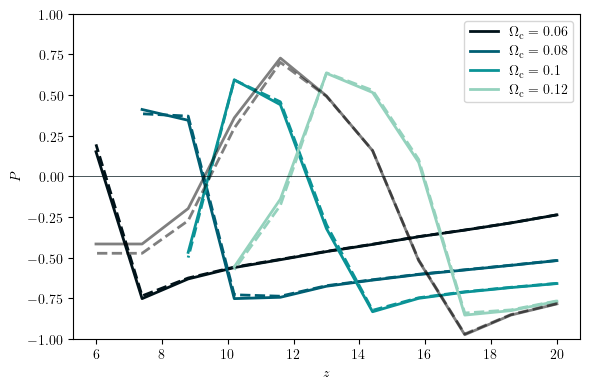

In [35]:
cross_correlation_real_plot(zvals, Lbox, Nbox)